# Classificació

### Libraries and loading data

In [92]:
import pandas as pd
from sklearn.svm import SVC
from skopt import BayesSearchCV
import numpy as np
np.int = int

from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

from sklearn.metrics import  ConfusionMatrixDisplay, classification_report, RocCurveDisplay
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
from numpy.random import choice

from yellowbrick.classifier.rocauc import roc_auc

import warnings
warnings.filterwarnings("ignore")

In [93]:
df_train = pd.read_csv('../datasets/data_train_class7.csv')
df_test = pd.read_csv('../datasets/data_test_class7.csv')

In [94]:
df_train.head()

,BPM,Energy,Danceability,Loudness,Liveness,Valence,Length,Acousticness,Speechiness,Popularity,is_recent,genre_0,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6
0,123,73,48,-8,11,87,140,57,17,65,1,0,0,0,0,1,0,0
1,99,21,34,-17,18,29,218,40,3,70,0,0,0,0,0,1,0,0
2,71,58,39,-7,22,38,295,47,3,63,0,1,0,0,0,0,0,0
3,135,23,40,-9,11,28,222,89,4,61,1,0,0,0,1,0,0,0
4,159,16,41,-22,12,42,199,88,3,77,0,0,1,0,0,0,0,0


In [95]:
x_train = df_train.drop(columns=['is_recent', 'Length'])
y_train = df_train['is_recent']

x_test = df_test.drop(columns=['is_recent', 'Length'])
y_test = df_test['is_recent']

clss = ['Pre-2000', 'Post-2000']

In [96]:
from sklearn.preprocessing import MinMaxScaler

data_columns = x_train.columns
scaler = MinMaxScaler()
x_train_norm = pd.DataFrame(scaler.fit_transform(x_train))
x_test_norm = pd.DataFrame(scaler.transform(x_test))
x_train_norm.columns = x_test_norm.columns = data_columns

x_train_norm.describe().T

,count,mean,std,min,25%,50%,75%,max
BPM,1395.0,0.456174,0.179555,0.0,0.318471,0.452229,0.557325,1.0
Energy,1395.0,0.583587,0.229908,0.0,0.401042,0.604167,0.770833,1.0
Danceability,1395.0,0.500500,0.179877,0.0,0.383721,0.500000,0.627907,1.0
Loudness,1395.0,0.723097,0.145117,0.0,0.640000,0.760000,0.840000,1.0
Liveness,1395.0,0.175110,0.169782,0.0,0.072165,0.103093,0.216495,1.0
Valence,1395.0,0.480615,0.258486,0.0,0.270833,0.458333,0.677083,1.0
Acousticness,1395.0,0.298786,0.296839,0.0,0.030612,0.183673,0.520408,1.0
Speechiness,1395.0,0.057672,0.082810,0.0,0.018868,0.037736,0.056604,1.0
Popularity,1395.0,0.542193,0.162211,0.0,0.426966,0.561798,0.674157,1.0
genre_0,1395.0,0.091039,0.287768,0.0,0.000000,0.000000,0.000000,1.0


## Oversampling y Undersampling

In [97]:
# print("ORIGINAL")
# print("Clase 0:", sum(y_train == 0))
# print("Clase 1:", sum(y_train == 1))
# rus = RandomUnderSampler(random_state=42)
# x_train_norm, y_train = rus.fit_resample(x_train_norm, y_train)
# print("OVERSAMPLING")
# print("Clase 0:", sum(y_train == 0))
# print("Clase 1:", sum(y_train == 1))

In [98]:
# print("ORIGINAL")
# print("Clase 0:", sum(y_train == 0))
# print("Clase 1:", sum(y_train == 1))
# rus = RandomOverSampler(random_state=42)
# x_train_norm, y_train = rus.fit_resample(x_train_norm, y_train)
# print("OVERSAMPLING")
# print("Clase 0:", sum(y_train == 0))
# print("Clase 1:", sum(y_train == 1))

## Models

In [99]:
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score


def save_results(clf, X_test, y_test, nclf, df):
    if hasattr(clf, 'best_score_'):
        df.loc[nclf,'train XV acc'] = clf.best_score_
    else:
        df.loc[nclf,'train XV acc'] = np.nan
    df.loc[nclf,'test acc'] = accuracy_score(y_test, clf.predict(X_test))
    df.loc[nclf,'test f1 score (0)'] = f1_score(y_test, clf.predict(X_test), pos_label=0)
    df.loc[nclf,'test f1 score (1)'] = f1_score(y_test, clf.predict(X_test), pos_label=1)
    df.loc[nclf,'test f1 score (W)'] = f1_score(y_test, clf.predict(X_test), average='macro')
    # df.loc[nclf,'ROC AUC'] = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
    return df

results_df = pd.DataFrame()

In [100]:
niter = 15
cv = 10

### Naive-Bayes

In [101]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV


In [102]:
gnb_model = GaussianNB().fit(x_train_norm, y_train)

print('Priors:', gnb_model.class_prior_)
print('Means:\n')
means = pd.DataFrame(gnb_model.theta_)
means.columns = x_train.columns
means

Priors: [0.59928315 0.40071685]
Means:



,BPM,Energy,Danceability,Loudness,Liveness,Valence,Acousticness,Speechiness,Popularity,genre_0,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6
0,0.452024,0.564132,0.497079,0.682775,0.170300,0.51008,0.317120,0.052022,0.555615,0.082536,0.488038,0.150718,0.050239,0.087321,0.105263,0.035885
1,0.462382,0.612683,0.505616,0.783399,0.182303,0.43655,0.271367,0.066122,0.522120,0.103757,0.191413,0.214669,0.150268,0.026834,0.268336,0.044723


In [103]:
print(classification_report(y_test, gnb_model.predict(x_test_norm),target_names=clss))
results_df = save_results(gnb_model, x_test_norm, y_test, 'GNB', results_df)

              precision    recall  f1-score   support

    Pre-2000       0.77      0.69      0.73       359
   Post-2000       0.60      0.70      0.64       240

    accuracy                           0.69       599
   macro avg       0.69      0.69      0.69       599
weighted avg       0.70      0.69      0.69       599



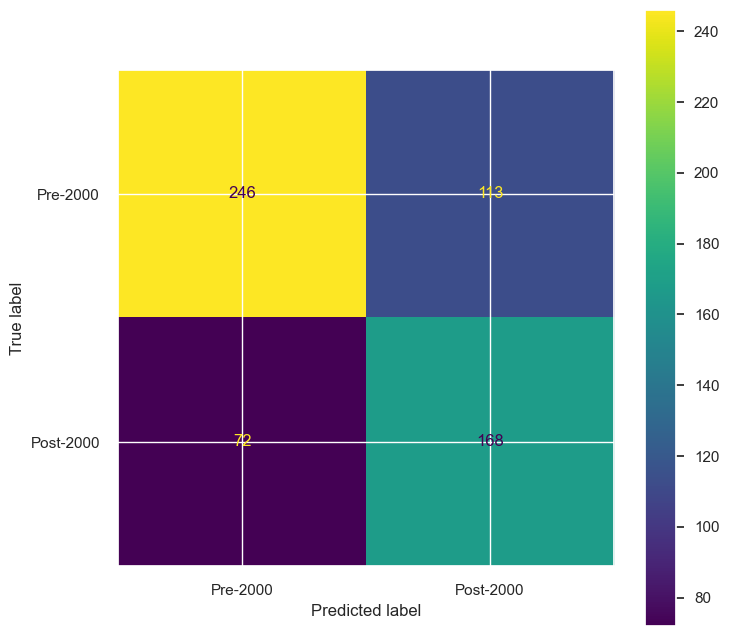

In [104]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(gnb_model, x_test_norm,y_test, display_labels=clss, ax=plt.subplot());

### LDA

In [105]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import  RandomOverSampler, SMOTE
from imblearn.pipeline import make_pipeline, Pipeline


param = {
    'solver': ['svd', 'lsqr', 'eigen'],
    'shrinkage': [None, 'auto', 0.1, 0.2, 0.5]
}

lda = GridSearchCV(LinearDiscriminantAnalysis(), 
                   param, 
                   cv=cv, 
                   n_jobs=-1, 
                   scoring='f1_weighted', 
                   refit=True).fit(x_train_norm, y_train);


show_html(pd.DataFrame(lda.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
5,"{'shrinkage': 'auto', 'solver': 'eigen'}",0.751254,1
4,"{'shrinkage': 'auto', 'solver': 'lsqr'}",0.751254,1
0,"{'shrinkage': None, 'solver': 'svd'}",0.750702,3
1,"{'shrinkage': None, 'solver': 'lsqr'}",0.733124,4
7,"{'shrinkage': 0.1, 'solver': 'lsqr'}",0.731266,5


In [106]:
print(classification_report(y_test, lda.predict(x_test_norm), target_names=clss))
results_df = save_results(lda, x_test_norm, y_test, 'LDA', results_df)

              precision    recall  f1-score   support

    Pre-2000       0.77      0.84      0.80       359
   Post-2000       0.71      0.62      0.66       240

    accuracy                           0.75       599
   macro avg       0.74      0.73      0.73       599
weighted avg       0.75      0.75      0.74       599



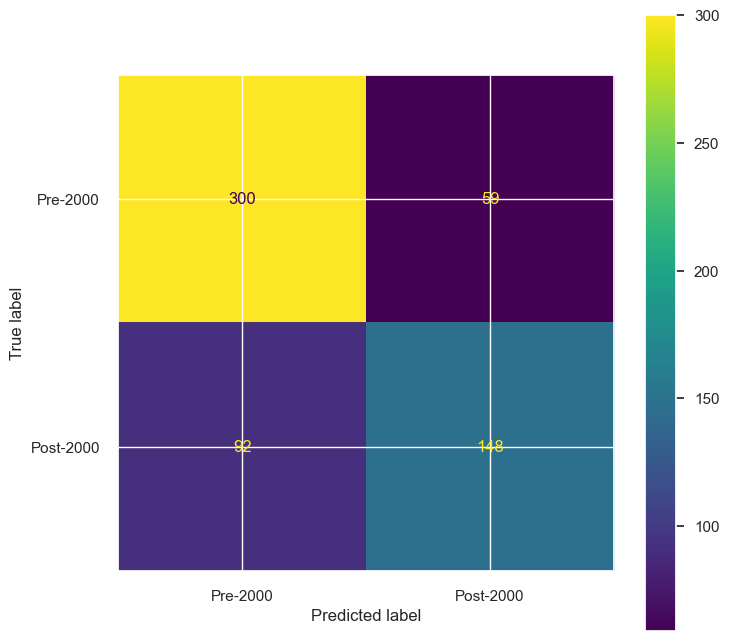

In [107]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(lda, x_test_norm,y_test, display_labels=clss, ax=plt.subplot());

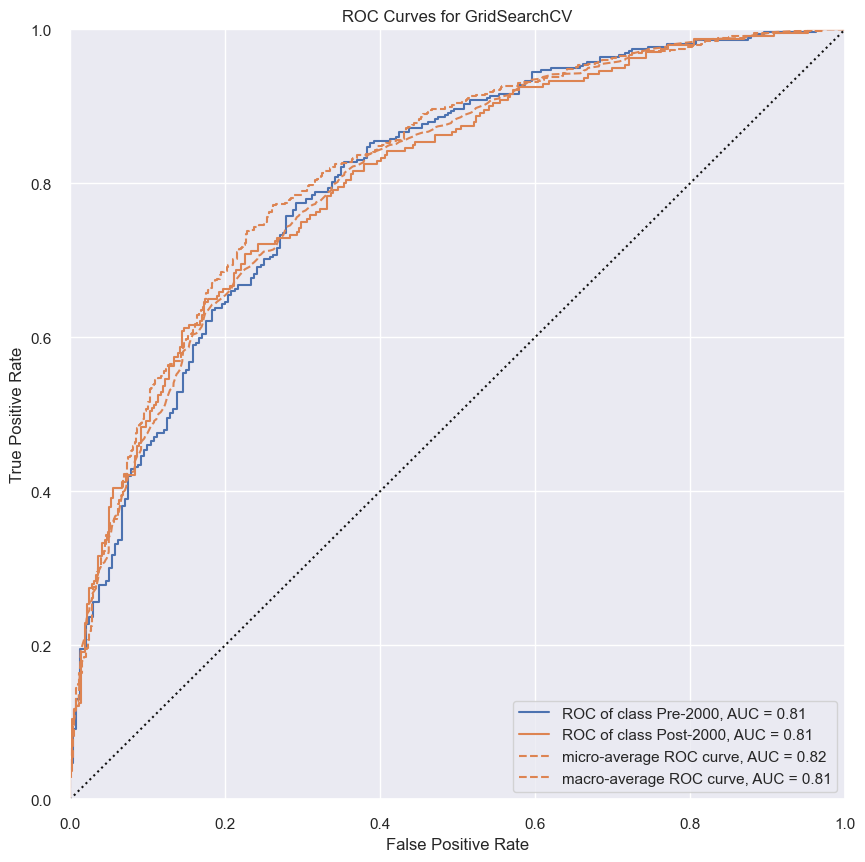

In [108]:
sns.set()
plt.figure(figsize=(10, 10));
roc_auc(lda, x_train_norm, y_train, x_test_norm, y_test, classes=clss);

In [109]:
c = choice(x_test_norm.shape[0], size=500, replace=False)
pi = permutation_importance(lda, x_test_norm.iloc[c], y_test.to_numpy()[c], n_jobs=-1, random_state=0)
var_imp_lda = pd.DataFrame({'importance': pi.importances_mean}, index=x_test_norm.columns)

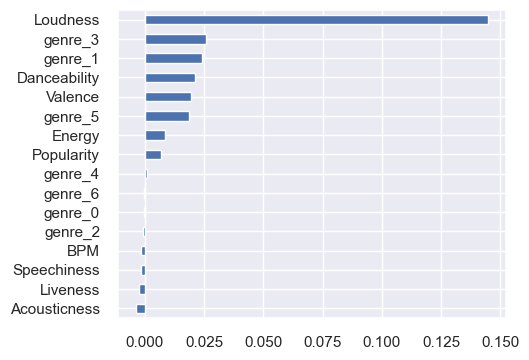

In [110]:
var_imp_lda.sort_values(by='importance').plot.barh(figsize=(5, 4), legend=False);

### QDA

In [116]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


param = {'reg_param':np.linspace(0,1,21, endpoint=True)}
qda =  GridSearchCV(QuadraticDiscriminantAnalysis(),
                    param,
                    cv=cv, 
                    n_jobs=-1, 
                    scoring='f1_weighted', 
                    refit=True).fit(x_train, y_train);

show_html(pd.DataFrame(qda.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

/usr/local/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.11/site-packages/sklearn/disc

,params,mean_test_score,rank_test_score
3,{'reg_param': 0.15000000000000002},0.752701,1
2,{'reg_param': 0.1},0.749936,2
4,{'reg_param': 0.2},0.747605,3
6,{'reg_param': 0.30000000000000004},0.746773,4
5,{'reg_param': 0.25},0.746222,5


In [ ]:
print(classification_report(y_test, qda.predict(x_test), target_names=clss))
results_df = save_results(qda, x_test, y_test, 'QDA', results_df)

In [ ]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(qda, x_test,y_test, display_labels=clss, ax=plt.subplot());

### SVM lineal

In [ ]:
from sklearn.model_selection import cross_val_score


param = {'C': 10**np.linspace(-3, 3, 101)}

lsvm = BayesSearchCV(SVC(kernel='linear', random_state=0), 
                     param, 
                     n_iter=niter,
                     cv=cv,
                     n_jobs=-1, 
                     refit=True, 
                     random_state=0, scoring='f1_weighted').fit(x_train, y_train)
# y_test_predicted_lsvm = lsvm.predict(x_test)

# r2_lsvm_train = np.mean(cross_val_score(lsvm, x_train, y_train))
# r2_lsvm_test = np.mean(cross_val_score(lsvm, x_test, y_test))

# print(f'Train R2 score: {r2_lsvm_train}')
# print(f'Test R2 score: {r2_lsvm_test}')

In [ ]:
show_html(pd.DataFrame(lsvm.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

In [ ]:
print(classification_report(y_test, lsvm.predict(x_test), target_names=clss))
results_df = save_results(lsvm, x_test, y_test, 'SVM Lineal', results_df)

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()


plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(lsvm, x_test, y_test, display_labels=clss, ax=plt.subplot());

### SVM Polinomial

In [ ]:
from sklearn.model_selection import StratifiedKFold


param = {
    'C': 10**np.linspace(-3, 3, 101),
    'degree':[2, 3]
}

# stratified_cv = StratifiedKFold(n_splits=cv, shuffle=True, random_state=0)

qsvm = BayesSearchCV(SVC(kernel='poly', random_state=0), 
                     param, 
                     n_iter=niter,
                     cv=cv, 
                     n_jobs=-1, 
                     refit=True, 
                     random_state=0, scoring='f1_weighted').fit(x_train_norm, y_train)
# y_test_predicted_qsvm = qsvm.predict(x_test)
# r2_qsvm_train = np.mean(cross_val_score(qsvm, x_train, y_train))
# r2_qsvm_test = np.mean(cross_val_score(qsvm, x_test, y_test))

# print(f'Train R2 score: {r2_qsvm_train}')
# print(f'Test R2 score: {r2_qsvm_test}')

In [ ]:
show_html(pd.DataFrame(qsvm.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

In [ ]:
print(classification_report(y_test, qsvm.predict(x_test_norm), target_names=clss))
results_df = save_results(qsvm, x_test_norm, y_test, 'SVM Polinomic', results_df)

In [ ]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(qsvm, x_test_norm, y_test, display_labels=clss, ax=plt.subplot());

In [ ]:
plt.figure(figsize=(10, 10));
roc_auc(qsvm, x_train_norm, y_train, x_test_norm, y_test, classes=clss, micro=False, macro=False);

### SVM RBF

Standardize the data.
Estandarización es menos sensible a outliers, proporcionando robustez frente a valores extremos que podrían distorsionar la eficacia del modelo

In [118]:
from sklearn.preprocessing import StandardScaler

data_columns = x_train.columns
scaler = StandardScaler()
x_train_standard = pd.DataFrame(scaler.fit_transform(x_train))
x_test_standard = pd.DataFrame(scaler.transform(x_test))
x_train_standard.columns = x_test_standard.columns = data_columns

x_train_standard.describe().T

,count,mean,std,min,25%,50%,75%,max
BPM,1395.0,-1.833659e-16,1.000359,-2.541494,-0.767187,-0.021979,0.563543,3.029828
Energy,1395.0,-6.366870e-17,1.000359,-2.539260,-0.794278,0.089544,0.814731,1.811863
Danceability,1395.0,-2.253872e-16,1.000359,-2.783460,-0.649451,-0.002781,0.708555,2.777897
Loudness,1395.0,-1.833659e-16,1.000359,-4.984636,-0.572824,0.254391,0.805867,1.908820
Liveness,1395.0,-5.857521e-17,1.000359,-1.031753,-0.606555,-0.424327,0.243841,4.860276
Valence,1395.0,4.838821e-17,1.000359,-1.860017,-0.811872,-0.086233,0.760346,2.010057
Acousticness,1395.0,-7.894919e-17,1.000359,-1.006920,-0.903756,-0.387933,0.746877,2.363121
Speechiness,1395.0,3.565447e-17,1.000359,-0.696687,-0.468760,-0.240834,-0.012908,11.383410
Popularity,1395.0,5.093496e-18,1.000359,-3.343712,-0.710606,0.120901,0.813824,2.823300
genre_0,1395.0,-4.838821e-17,1.000359,-0.316477,-0.316477,-0.316477,-0.316477,3.159787


Default model

In [119]:
# from sklearn.model_selection import cross_val_score, StratifiedKFold

In [120]:
# stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [121]:
rbfsvm_default = SVC(kernel='rbf', random_state=0)
rbfsvm_default.fit(x_train_standard, y_train)
y_pred = rbfsvm_default.predict(x_test_standard);
print(classification_report(y_test,y_pred));
print(f1_score(y_test, y_pred, average='weighted'))
cv_f1_score = cross_val_score(SVC(random_state=0), X=x_train_standard,  y=y_train, cv=5, scoring='f1_weighted',n_jobs=-1)
print("5-fold CV f1-score: ", cv_f1_score.mean())

              precision    recall  f1-score   support

           0       0.78      0.83      0.80       359
           1       0.72      0.64      0.68       240

    accuracy                           0.75       599
   macro avg       0.75      0.74      0.74       599
weighted avg       0.75      0.75      0.75       599

0.7519776637080713
5-fold CV f1-score:  0.7540630239684611


BayesSearchCV (and later GridSearch) for tunning (done multiple times with different ranges)

In [122]:
np.logspace(-3, 3, 10)

array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03])

In [123]:
param = {'C':10**np.linspace(-1,1,50),
         'gamma': ['auto', 'scale']
        #  'gamma': np.logspace(-3, 3, 7)
         }

# rbfsvm = BayesSearchCV(SVC(kernel='rbf', random_state=0), 
#                      param, 
#                      cv=5,
#                      scoring='f1_weighted',
#                      n_jobs=-1, 
#                      refit=True, 
#                      random_state=0).fit(x_train_standard, y_train)

rbfsvm = GridSearchCV(SVC(kernel='rbf', random_state=0), 
                     param, 
                     cv=5,
                     scoring='f1_weighted',
                     n_jobs=-1, 
                     refit=True).fit(x_train_standard, y_train)


In [124]:
show_html(pd.DataFrame(rbfsvm.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
65,"{'C': 2.0235896477251565, 'gamma': 'scale'}",0.758446,1
64,"{'C': 2.0235896477251565, 'gamma': 'auto'}",0.758446,1
55,"{'C': 1.2648552168552958, 'gamma': 'scale'}",0.756714,3
61,"{'C': 1.6768329368110073, 'gamma': 'scale'}",0.756054,4
60,"{'C': 1.6768329368110073, 'gamma': 'auto'}",0.756054,4


In [125]:
# scores = rbfsvm.cv_results_['mean_test_score']
# scores = np.array(scores).reshape(len(param['gamma']), len(param['C']))

# plt.figure(figsize=(2, 1))
# plt.matshow(scores)
# plt.ylabel('gamma')
# plt.xlabel('C')
# plt.colorbar()
# plt.yticks(np.arange(len(param['gamma'])), param['gamma'],rotation='horizontal')
# plt.xticks(np.arange(len(param['C'])), param['C'], rotation='vertical')
# plt.show()

In [126]:
rbfsvm.best_params_

{'C': 2.0235896477251565, 'gamma': 'auto'}

In [127]:
print(classification_report(y_test, rbfsvm.predict(x_test_standard), target_names=clss))
results_df = save_results(rbfsvm, x_test_standard, y_test, 'SVM RBF', results_df)

              precision    recall  f1-score   support

    Pre-2000       0.82      0.78      0.80       380
   Post-2000       0.65      0.71      0.68       219

    accuracy                           0.75       599
   macro avg       0.73      0.74      0.74       599
weighted avg       0.76      0.75      0.75       599



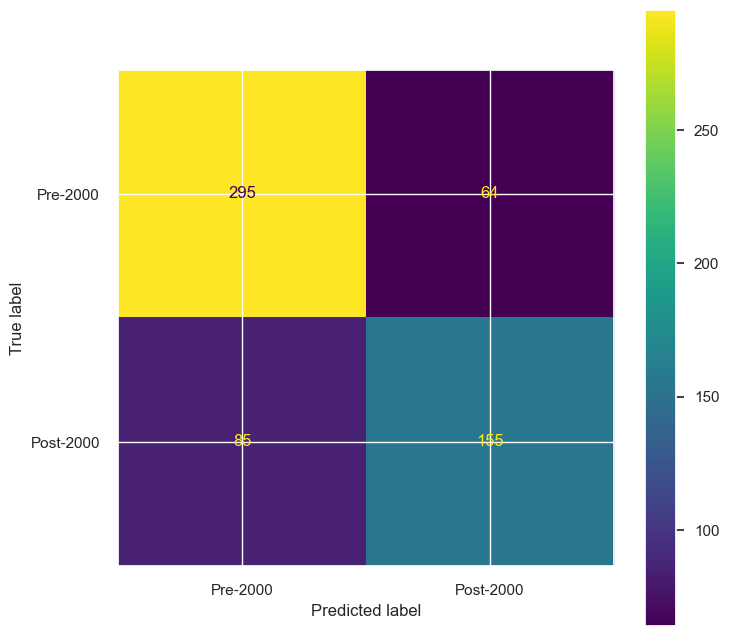

In [128]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(rbfsvm, x_test_standard, y_test, display_labels=clss, ax=plt.subplot());

Best model

In [129]:
y_pred = rbfsvm.predict(x_test_standard);
print(classification_report(y_test,y_pred));
print(f1_score(y_test, y_pred, average='weighted'))
results_df = save_results(rbfsvm, x_test_standard, y_test, 'SVM RBF', results_df)

              precision    recall  f1-score   support

           0       0.78      0.82      0.80       359
           1       0.71      0.65      0.68       240

    accuracy                           0.75       599
   macro avg       0.74      0.73      0.74       599
weighted avg       0.75      0.75      0.75       599

0.749096082363327


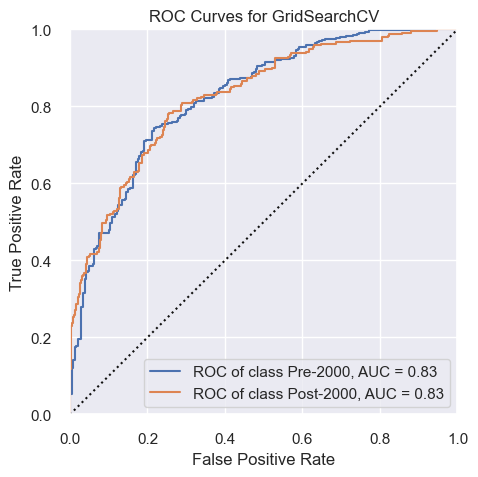

In [130]:
plt.figure(figsize=(5, 5));
roc_auc(rbfsvm, x_train_standard, y_train, x_test_standard, y_test, classes=clss, micro=False, macro=False);

Permutation importance

In [131]:
c = choice(x_test_standard.shape[0], size=500, replace=False)
pi = permutation_importance(rbfsvm, x_test_standard.iloc[c], y_test.to_numpy()[c], n_jobs=-1, random_state=0)
var_imp_knn = pd.DataFrame({'importance': pi.importances_mean}, index=x_test_standard.columns)

In [ ]:
var_imp_knn.sort_values(by='importance').plot.barh(figsize=(5, 4), legend=False);

### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier


param = {'n_neighbors':[1, 3, 5, 7, 11, 15], 
          'weights':['distance', 'uniform'], 
          'leaf_size':[1, 5, 10, 20, 30],
          'metric': ['l2', 'l1', 'cosine']}

knn = BayesSearchCV(KNeighborsClassifier(), 
                     param, 
                     n_iter=niter,
                     cv=cv,
                     scoring='f1_weighted', 
                     n_jobs=-1, 
                     refit=True, 
                     random_state=0).fit(x_train, y_train)
# y_test_predicted_knn = knn.predict(x_test)
# r2_knn_train = np.mean(cross_val_score(knn, x_train, y_train))
# r2_knn_test = np.mean(cross_val_score(knn, x_test, y_test))

# print(f'Train R2 score: {r2_knn_train}')
# print(f'Test R2 score: {r2_knn_test}')

In [ ]:
show_html(pd.DataFrame(knn.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

In [ ]:
print(classification_report(y_test, knn.predict(x_test), target_names=clss))
results_df = save_results(knn, x_test, y_test, 'KNN', results_df)

In [ ]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(knn, x_test, y_test, display_labels=clss, ax=plt.subplot());

In [ ]:
plt.figure(figsize=(10, 10));
roc_auc(knn, x_train, y_train, x_test, y_test, classes=clss);

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier


param = {'n_estimators': [5,10,25,40, 50, 75,100, 200], 
         'criterion':['gini', 'entropy'], 
         'max_depth':[None, 1, 2, 3,  5,  8, 9,10,15],
         'min_samples_leaf':[1,2,3,5,10]}

rforest = BayesSearchCV(RandomForestClassifier(), 
                        param, n_iter=niter, cv=cv, scoring='f1_weighted', n_jobs=-1, refit=True, random_state=0).fit(x_train, y_train)
# y_test_predicted_rforest = rforest.predict(x_test)
# r2_rforest_train = np.mean(cross_val_score(rforest, x_train, y_train))
# r2_rforest_test = np.mean(cross_val_score(rforest, x_test, y_test))

# print(f'Train R2 score: {r2_rforest_train}')
# print(f'Test R2 score: {r2_rforest_test}')

In [ ]:
show_html(pd.DataFrame(rforest.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

In [ ]:
print(classification_report(y_test, rforest.predict(x_test), target_names=clss))
results_df = save_results(rforest, x_test, y_test, 'Random Forest', results_df)

In [ ]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(rforest, x_test, y_test, display_labels=clss, ax=plt.subplot());

### Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier


param = {'n_estimators': [5,10,25,40, 50, 75,100, 200], 
         'loss':['log_loss', 'exponential'], 
         'criterion':['friedman_mse', 'squared_error'], 
         'max_depth':[None, 1, 2, 3,  5,  8, 9,10,15],
         'min_samples_leaf':[1,2,3,5,10], 
         'learning_rate':[0.1,0.5, 1,3, 5, 10, 15]}

gboost = BayesSearchCV(GradientBoostingClassifier(random_state=0, n_iter_no_change=5), 
                        param, 
                        n_iter=15,
                        cv=cv, 
                        n_jobs=-1, 
                        refit=True, 
                        random_state=0, scoring='f1_weighted').fit(x_train, y_train)
# y_test_predicted_gboost = gboost.predict(x_test)
# r2_gboost_train = np.mean(cross_val_score(gboost, x_train, y_train))
# r2_gboost_test = np.mean(cross_val_score(gboost, x_test, y_test))

# print(f'Train R2 score: {r2_gboost_train}')
# print(f'Test R2 score: {r2_gboost_test}')

In [ ]:
show_html(pd.DataFrame(gboost.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

In [ ]:
print(classification_report(y_test, gboost.predict(x_test), target_names=clss))
results_df = save_results(gboost, x_test, y_test, 'Gradient Boosting', results_df)

In [ ]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(gboost, x_test, y_test, display_labels=clss, ax=plt.subplot());

### MLP

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
param = {'hidden_layer_sizes':[2, 4, 8, 12, 16, 32, 64, 100, 200], 
         'activation':['relu', 'logistic', 'identity', 'tanh'], 
         'learning_rate_init': np.logspace(-5, 1, 10),
        'solver': ['adam', 'lbfgs', 'sgd']}

mlp =  BayesSearchCV(MLPClassifier(max_iter=10000, early_stopping=True, n_iter_no_change=20,learning_rate='adaptive',random_state=0), 
                     param, cv=cv, n_jobs=-1, refit=True, scoring='f1_weighted').fit(x_train_norm, y_train)

In [ ]:
show_html(pd.DataFrame(mlp.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

In [ ]:
y_pred = mlp.predict(x_test_norm);
print(classification_report(y_test,y_pred));
print(f1_score(y_test, y_pred, average='weighted'))
results_df = save_results(mlp, x_test_norm, y_test, 'MLP', results_df)


In [ ]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(mlp, x_test_norm, y_test, display_labels=clss, ax=plt.subplot());

In [ ]:
plt.figure(figsize=(5, 5));
roc_auc(mlp, x_train_standard, y_train, x_test_standard, y_test, classes=clss, micro=False, macro=False);

In [ ]:
c = choice(x_test_standard.shape[0], size=500, replace=False)
pi = permutation_importance(mlp, x_test_standard.iloc[c], y_test.to_numpy()[c], n_jobs=-1, random_state=0)
var_imp_mlp = pd.DataFrame({'importance': pi.importances_mean}, index=x_test_standard.columns)

In [ ]:
var_imp_mlp.sort_values(by='importance').plot.barh(figsize=(5, 4), legend=False);

### Neural network tensorFlow

In [ ]:
from tensorflow import keras


model = keras.Sequential()
model.add(keras.Input(shape=(x_train.shape[1])))
model.add(keras.layers.Dense(64, activation='relu', kernel_regularizer='l2'))
model.add(keras.layers.Dense(32, activation='relu', kernel_regularizer='l2'))
model.add(keras.layers.Dense(1, activation='linear', kernel_regularizer='l2'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='AUC')
model.fit(x_train, y_train, batch_size=64, epochs=150, verbose=0, validation_split=0.2)

y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype(int)

accuracy = f1_score(y_test, y_pred)
print(f'Test f1-score: {accuracy:.4f}')

In [ ]:
# results_df = save_results(model, x_test, y_test, 'Neural Network', results_df)

In [ ]:
# plt.figure(figsize=(8,8));
# ConfusionMatrixDisplay.from_estimator(model, x_test, y_test, display_labels=clss, ax=plt.subplot());

## Combinacions de classifiers

### Stacking Classifier

In [117]:
from sklearn.ensemble import StackingClassifier


stacls = StackingClassifier([('rbfsvm', rbfsvm.best_estimator_),
                            ('mlp', mlp.best_estimator_)],
                            n_jobs=-1).fit(x_train, y_train)

NameError: name 'rbfsvm' is not defined

In [ ]:
print(classification_report(y_test, stacls.predict(x_test), target_names=clss))
results_df = save_results(stacls, x_test, y_test, 'Stacking (RBF + MLP)', results_df)

In [ ]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(stacls, x_test, y_test, display_labels=clss, ax=plt.subplot());

In [ ]:
stacls2 = StackingClassifier([('rbfsvm', rbfsvm.best_estimator_),
                            ('lda', lda.best_estimator_)],
                            n_jobs=-1).fit(x_train, y_train)

In [ ]:
print(classification_report(y_test, stacls2.predict(x_test), target_names=clss))
results_df = save_results(stacls2, x_test, y_test, 'Stacking (RBF + LDA)', results_df)

In [ ]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(stacls2, x_test, y_test, display_labels=clss, ax=plt.subplot());

### Voting Classifier

In [ ]:
from sklearn.ensemble import VotingClassifier


votcls = VotingClassifier([('rbfsvm', rbfsvm.best_estimator_),
                            ('mlp', mlp.best_estimator_)],
                            n_jobs=-1).fit(x_train, y_train)

In [ ]:
print(classification_report(y_test, votcls.predict(x_test), target_names=clss))
results_df = save_results(votcls, x_test, y_test, 'Voting (RBF + MLP)', results_df)

In [ ]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(votcls, x_test, y_test, display_labels=clss, ax=plt.subplot());

In [ ]:
votcls2 = VotingClassifier([('rbfsvm', rbfsvm.best_estimator_),
                            ('lda', lda.best_estimator_)],
                            n_jobs=-1).fit(x_train, y_train)

In [ ]:
print(classification_report(y_test, votcls2.predict(x_test), target_names=clss))
results_df = save_results(votcls2, x_test, y_test, 'Voting (RBF + LDA)', results_df)

In [ ]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(votcls2, x_test, y_test, display_labels=clss, ax=plt.subplot());

## Conclusions

In [ ]:
results_sorted = results_df.sort_values(by=['test f1 score (W)'], ascending=False)
results_sorted

In [ ]:
plt.figure(figsize=(10, 6))
results_sorted['test f1 score (W)'].plot(kind='bar', color='skyblue')
plt.title('F1-Scores dels Models')
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.ylim(0.0, 1.0)
plt.xticks(rotation=45, ha='right')
plt.show()